In [ ]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt

import numpy as np

In [ ]:
torch.__version__

'2.0.0+cu118'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def victoria_Series():
  df = pd.read_csv('victoria.csv')
  df['date'] = pd.to_datetime(df['date'])
  df_victoria = df.set_index('date')
  df2 = df_victoria.resample('M').mean()

  fig = px.line(df2, x=df2.index, y='demand', title='Energy Demand')
  fig.update_xaxes(
      rangeslider_visible = True,
      rangeselector = dict(
          buttons = list([
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(count=2, label="3y", step="year", stepmode="backward"),
              dict(count=3, label="5y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
  fig.show()
  series = torch.tensor(df2['demand'].values, dtype=torch.float32)
  return series


In [ ]:
def NYC_Series():
  df = pd.read_csv('NYC_Energy_Consumption.csv')
  df.rename(columns = {'    timeStamp' : 'timeStamp'}, inplace = True)
  df['timeStamp'] = pd.to_datetime(df['timeStamp']).dt.date
  df['timeStamp'] = pd.to_datetime(df['timeStamp'])
  df2 = df.groupby('timeStamp')['demand'].sum().to_frame()
  df2.dropna()
  fig = px.line(df2, x=df2.index, y='demand', title='Energy Demand')
  fig.update_xaxes(
      rangeslider_visible = True,
      rangeselector = dict(
          buttons = list([
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(count=2, label="3y", step="year", stepmode="backward"),
              dict(count=3, label="5y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
  fig.show()
  series = torch.tensor(df2['demand'].values, dtype=torch.float32)
  return series

In [ ]:
def UK_Series():
  df = pd.read_csv('historic_demand_2009_2023_noNaN.csv')
  df['settlement_date'] = pd.to_datetime(df['settlement_date']).dt.date
  df['settlement_date'] = pd.to_datetime(df['settlement_date'])
  df_uk = df.groupby('settlement_date')['nd'].sum().to_frame()
  df2 = df_uk.resample('M').sum()
  fig = px.line(df, x=df.index, y='nd', title='Energy Demand')
  fig.update_xaxes(
      rangeslider_visible = True,
      rangeselector = dict(
          buttons = list([
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(count=2, label="3y", step="year", stepmode="backward"),
              dict(count=3, label="5y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
  fig.show()
  series = torch.tensor(df2['nd'].values, dtype=torch.float32)
  return series

In [ ]:
series = victoria_Series()
series

<ipython-input-7-8befffdfa9ca>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df_victoria.resample('M').mean()


tensor([120576.8594, 128754.1094, 117730.7031, 119606.6016, 125072.1016,
        134137.9219, 137856.0625, 132113.7500, 123427.2109, 117135.6719,
        115927.9141, 123824.1250, 120292.7422, 124767.8438, 124549.9219,
        116731.0156, 119950.5469, 133713.5000, 131618.3281, 131178.2812,
        122656.6797, 115029.6094, 115241.0234, 108336.5938, 112818.7266,
        114614.8906, 117311.8828, 107725.2500, 120448.6484, 131431.6094,
        129783.9453, 129554.9297, 119511.0547, 111114.9219, 119519.9453,
        113257.6016, 124734.3047, 120497.8984, 112401.2266, 113133.7266,
        121962.1562, 132360.8125, 130229.7266, 127169.5078, 116315.6016,
        108353.5391, 107120.8516, 111407.1328, 121811.6016, 116140.1328,
        116620.2344, 108626.4766, 119186.1328, 129648.0469, 128956.1328,
        127866.6172, 116283.3984, 110946.7109, 108392.6172, 110338.9922,
        114344.9531, 114349.6875, 108709.8906, 107647.5469, 117985.7188,
        129347.3281, 132352.0938, 123475.7109, 1085

In [ ]:
series = NYC_Series()
series

In [ ]:
series = UK_Series()
series

In [ ]:
def create_dataset(series, lookback):
  X, Y = [], []
  for i in range(series.shape[0]-lookback):
    X.append(series[i : i+lookback])
    Y.append(series[i+lookback])
  X, Y = torch.stack(X), torch.stack(Y).reshape(-1,1)
  train_size = int(X.shape[0] * 0.80)
  X_train, X_test = X[:train_size], X[train_size:]
  Y_train, Y_test = Y[:train_size], Y[train_size:]
  return X_train, X_test, Y_train, Y_test

In [ ]:
class AutoLSTM(nn.Module):
  def __init__(self, hidden_size=50):
    super(AutoLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size=lookback, hidden_size=hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
    self.linear = nn.Linear(hidden_size * 2, 1)

  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.linear(x)
    return x

In [ ]:
lookback = 24
X_train, X_test, Y_train, Y_test = create_dataset(series, lookback)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

autolstm = AutoLSTM(hidden_size=50)
optimiser = optim.Adam(autolstm.parameters(), lr=0.3, weight_decay=0.05, amsgrad=True)
lossfn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, Y_train), shuffle=True, batch_size=8)

print(autolstm)

best_autolstm = autolstm
best_acc = 1000000000
n_epochs = 3000
for epoch in range(n_epochs):
  autolstm.train()
  for X_batch, Y_batch in loader:
    Y_pred = autolstm(X_batch)
    loss = lossfn(Y_pred, Y_batch)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  if epoch % 100 == 0:
    autolstm.eval()
    with torch.no_grad():
      Y_pred = autolstm(X_train)
      train_rmse = np.sqrt(lossfn(Y_pred, Y_train))
      Y_pred = autolstm(X_test)
      test_rmse = np.sqrt(lossfn(Y_pred, Y_test))
      print("improvement : ", best_acc - test_rmse)
      if test_rmse < best_acc:
        best_acc = test_rmse
        best_autolstm = autolstm
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

torch.Size([36, 24]) torch.Size([10, 24]) torch.Size([36, 1]) torch.Size([10, 1])
AutoLSTM(
  (lstm): LSTM(24, 50, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
improvement :  tensor(9.9988e+08)
Epoch 0: train RMSE 118723.5547, test RMSE 116431.8281
improvement :  tensor(13370.4062)
Epoch 100: train RMSE 105190.2031, test RMSE 103061.4219
improvement :  tensor(13291.7422)
Epoch 200: train RMSE 91688.3516, test RMSE 89769.6797
improvement :  tensor(11785.1250)
Epoch 300: train RMSE 79735.1172, test RMSE 77984.5547
improvement :  tensor(11452.8828)
Epoch 400: train RMSE 68088.4531, test RMSE 66531.6719
improvement :  tensor(10263.3047)
Epoch 500: train RMSE 57637.9141, test RMSE 56268.3672
improvement :  tensor(9450.7461)
Epoch 600: train RMSE 47995.1133, test RMSE 46817.6211
improvement :  tensor(8092.2461)
Epoch 700: train RMSE 39721.1211, test RMSE 38725.3750
improvement :  tensor(6343.3340)
Epoch 800:

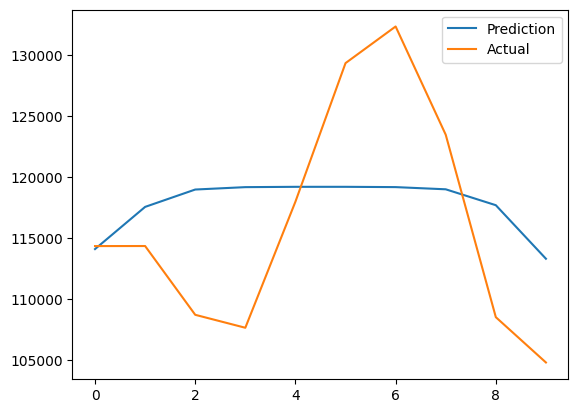

In [ ]:
_, X_test, _, Y_test = create_dataset(series, lookback)

Y_pred = best_autolstm(X_test)
Y_pred = Y_pred.reshape(Y_pred.shape[0])

Y_test.reshape(Y_test.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])

plt.plot(Y_pred.detach().numpy(), label="Prediction")
plt.plot(Y_test.detach().numpy(), label="Actual")
plt.legend()
plt.show()

In [ ]:
class CNNLSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=1):
    super(CNNLSTM, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=output_dim, kernel_size=kernel_size)
    self.sigmoid1 = nn.Sigmoid()
    self.lstm1 = nn.LSTM(output_dim, hidden_dim, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.sigmoid1(x)
    x = x.permute(0, 2, 1)
    x, _ = self.lstm1(x)
    x = self.fc1(x[:, -1, :])

    return x

In [ ]:
def reshape_data(X_train, X_test, Y_train, Y_test, L_in):
  X_train = X_train.unsqueeze(2).reshape(X_train.shape[0], X_train.shape[1]//L_in, L_in)
  Y_train = Y_train.unsqueeze(1)
  X_test = X_test.unsqueeze(2).reshape(X_test.shape[0], X_test.shape[1]//L_in, L_in)
  Y_test = Y_test.unsqueeze(1)
  return X_train, X_test, Y_train, Y_test

lookback = 30
L_in = 2
X_train, X_test, Y_train, Y_test = create_dataset(series, lookback)
X_train, X_test, Y_train, Y_test = reshape_data(X_train, X_test, Y_train, Y_test, L_in)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

cnnlstm = CNNLSTM(input_dim = lookback//L_in, hidden_dim = 60, output_dim=48, kernel_size=2)
optimiser = optim.Adam(cnnlstm.parameters(), lr=0.7, weight_decay=0.05, amsgrad=True)
lossfn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, Y_train), shuffle=True, batch_size=8)

print(cnnlstm)

best_cnnlstm = cnnlstm
best_cnnlstm_acc = 1000000000
n_epochs = 50000
for epoch in range(n_epochs):
  cnnlstm.train()
  for X_batch, Y_batch in loader:
    Y_pred = cnnlstm(X_batch)
    loss = lossfn(Y_pred, Y_batch)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  if epoch % 100 == 0:
    cnnlstm.eval()
    with torch.no_grad():
      Y_pred = cnnlstm(X_train)
      train_rmse = np.sqrt(lossfn(Y_pred, Y_train))
      Y_pred = cnnlstm(X_test)
      test_rmse = np.sqrt(lossfn(Y_pred, Y_test))
      print("improvement : ", best_cnnlstm_acc - test_rmse)
      if test_rmse < best_cnnlstm_acc:
        best_cnnlstm_acc = test_rmse
        best_cnnlstm = cnnlstm
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

torch.Size([32, 15, 2]) torch.Size([8, 15, 2]) torch.Size([32, 1, 1]) torch.Size([8, 1, 1])
CNNLSTM(
  (conv1): Conv1d(15, 48, kernel_size=(2,), stride=(1,))
  (sigmoid1): Sigmoid()
  (lstm1): LSTM(48, 60, batch_first=True)
  (fc1): Linear(in_features=60, out_features=1, bias=True)
)
improvement :  tensor(9.9988e+08)
Epoch 0: train RMSE 118670.5234, test RMSE 116964.5547


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



improvement :  tensor(7999.8516)
Epoch 100: train RMSE 110656.5391, test RMSE 108964.7031
improvement :  tensor(7824.5000)
Epoch 200: train RMSE 102815.9922, test RMSE 101140.2031
improvement :  tensor(7867.1250)
Epoch 300: train RMSE 94929.9766, test RMSE 93273.0781
improvement :  tensor(7568.2812)
Epoch 400: train RMSE 87340.0938, test RMSE 85704.7969
improvement :  tensor(7550.3125)
Epoch 500: train RMSE 79763.9688, test RMSE 78154.4844
improvement :  tensor(7359.9219)
Epoch 600: train RMSE 72373.3438, test RMSE 70794.5625
improvement :  tensor(6878.0781)
Epoch 700: train RMSE 65459.9102, test RMSE 63916.4844
improvement :  tensor(6165.6367)
Epoch 800: train RMSE 59255.0820, test RMSE 57750.8477
improvement :  tensor(5580.2578)
Epoch 900: train RMSE 53630.9141, test RMSE 52170.5898
improvement :  tensor(5536.5000)
Epoch 1000: train RMSE 48039.8086, test RMSE 46634.0898
improvement :  tensor(4785.7227)
Epoch 1100: train RMSE 43194.4062, test RMSE 41848.3672
improvement :  tensor(4564

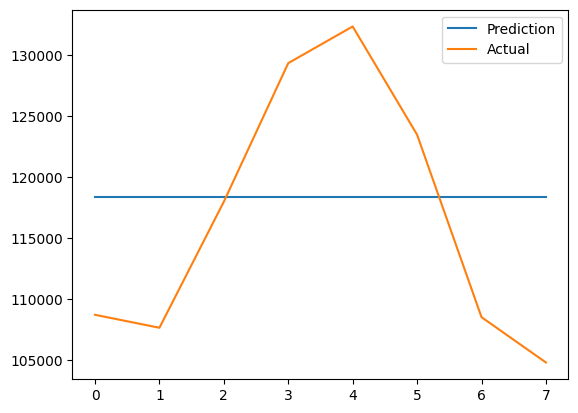

In [ ]:
X_train, X_test, Y_train, Y_test = create_dataset(series, lookback)
_, X_test, _, Y_test = reshape_data(X_train, X_test, Y_train, Y_test, L_in)

Y_pred = best_cnnlstm(X_test)
Y_pred = Y_pred.reshape(Y_pred.shape[0])

Y_test.reshape(Y_test.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])

plt.plot(Y_pred.detach().numpy(), label="Prediction")
plt.plot(Y_test.detach().numpy(), label="Actual")
plt.legend()
plt.show()